In [1]:
from algorithms import *
from utils import *
from math import log

In [2]:
arm_sets = np.load('results/small_instances_N_20_K_20_T_1e4_k_10/arm_sets.npz')
# arm_sets = np.load('results/larger_instances_N_100_K_40_T_1e4_k_20/arm_sets.npz')
arm_sets = arm_sets['arm_sets']

reward_avgs = np.load("results/small_instances_N_20_K_20_T_1e4_k_10/means.npz")
# reward_avgs = np.load("results/larger_instances_N_100_K_40_T_1e4_k_20/means.npz")
reward_avgs = reward_avgs['tmp']

In [3]:
## Generate Graphs
num_clusters = 2  # for SBM
size_cluster = 10
# size_cluster = 50   # for large instances
N = size_cluster * num_clusters  # number of agents
er_p = 2 * log(N) / N
# er_p = 1.001 * log(N) / N  # for large instances

## Erodos-Renyi
# if the graph is disconnected, keep trying other seeds until the graph is connected.
u = 2023
while not nx.is_connected(nx.erdos_renyi_graph(N, er_p, seed=u)):
    u += 1
Network_ER = nx.erdos_renyi_graph(N, er_p, seed=u)
print(nx.is_connected(Network_ER))

# Barabasi-Albert
m = 5
# m = 3   # for large instance
Network_BA = nx.barabasi_albert_graph(N, m, seed=2023)
print(nx.is_connected(Network_BA))

## Binary SBM
sbm_p, sbm_q = 2 * er_p, 0.01
# sbm_p, sbm_q = 2 * er_p, 0.001  # for large instances
u = 2023
while not nx.is_connected(nx.random_partition_graph([size_cluster for _ in range(num_clusters)], sbm_p, sbm_q, seed=u)):
    u += 1
Network_SBM = nx.random_partition_graph([size_cluster for _ in range(num_clusters)], sbm_p, sbm_q, seed=u)
print(nx.is_connected(Network_SBM))

True
True
True


In [4]:
K = 20
# K = 40  # for large instances

gammas = range(1, 10)

def F(gamma):
    _, delta_ER = compute_invariants(Network_ER, arm_sets, reward_avgs, K, gamma)
    _, delta_BA = compute_invariants(Network_BA, arm_sets, reward_avgs, K, gamma)
    _, delta_SBM = compute_invariants(Network_SBM, arm_sets, reward_avgs, K, gamma)
    return delta_ER, delta_BA, delta_SBM

with Pool() as pool:
    finals = pool.map_async(F, gammas)
    finals = finals.get()

delta_ERs, delta_BAs, delta_SBMs = zip(*finals)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/junghyun/anaconda3/envs/bandits/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/759765d2b9e94aa69329de2d744c3e44-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/759765d2b9e94aa69329de2d744c3e44-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 115 COLUMNS
At line 646 RHS
At line 757 BOUNDS
At line 868 ENDATA
Problem MODEL has 110 rows, 110 columns and 300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1 - 0.00 seconds
Cgl0004I processed model has 110 rows, 110 columns (110 integer (110 of which binary)) and 300 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0045I 10 integer variables out of 110 objects (110 integer) have cost of 1 - high priority
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial state

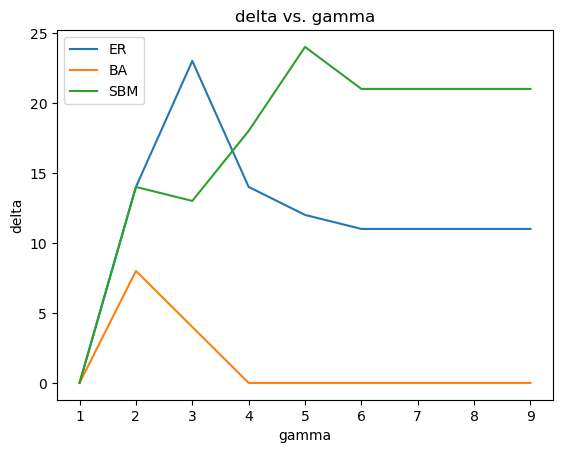

In [8]:
np.savez("results/small_instances_N_20_K_20_T_1e4_k_10/deltas.npz", delta_ERs=delta_ERs, delta_BAs=delta_BAs, delta_SBMs=delta_SBMs)

plt.plot(gammas, delta_ERs, label="ER")
plt.plot(gammas, delta_BAs, label="BA")
plt.plot(gammas, delta_SBMs, label="SBM")
plt.legend()
plt.title("delta vs. gamma")
plt.xlabel("gamma")
plt.ylabel("delta")
plt.savefig("results/small_instances_N_20_K_20_T_1e4_k_10/deltas.pdf", dpi=500)
plt.show()
